In [71]:
from qiskit import QuantumCircuit, QuantumRegister, AncillaRegister, Aer
from qiskit.quantum_info import Statevector
from qiskit.visualization import array_to_latex, plot_histogram

In [191]:
accept = QuantumRegister(1, name="accept")
detain = QuantumRegister(1, name="detain")
justify = QuantumRegister(1, name="justify")

bribe = QuantumRegister(1, name="bribe")
false_info = QuantumRegister(1, name="false_info")
wanted = QuantumRegister(1, name="wanted")

passport = QuantumRegister(1, name="passport")
other_documents = QuantumRegister(1, name="documents")

attack = QuantumRegister(1, name="terrorist_attack")
weapon = QuantumRegister(1, name="use_weapon")

ancilla = AncillaRegister(2, name="ancilla")

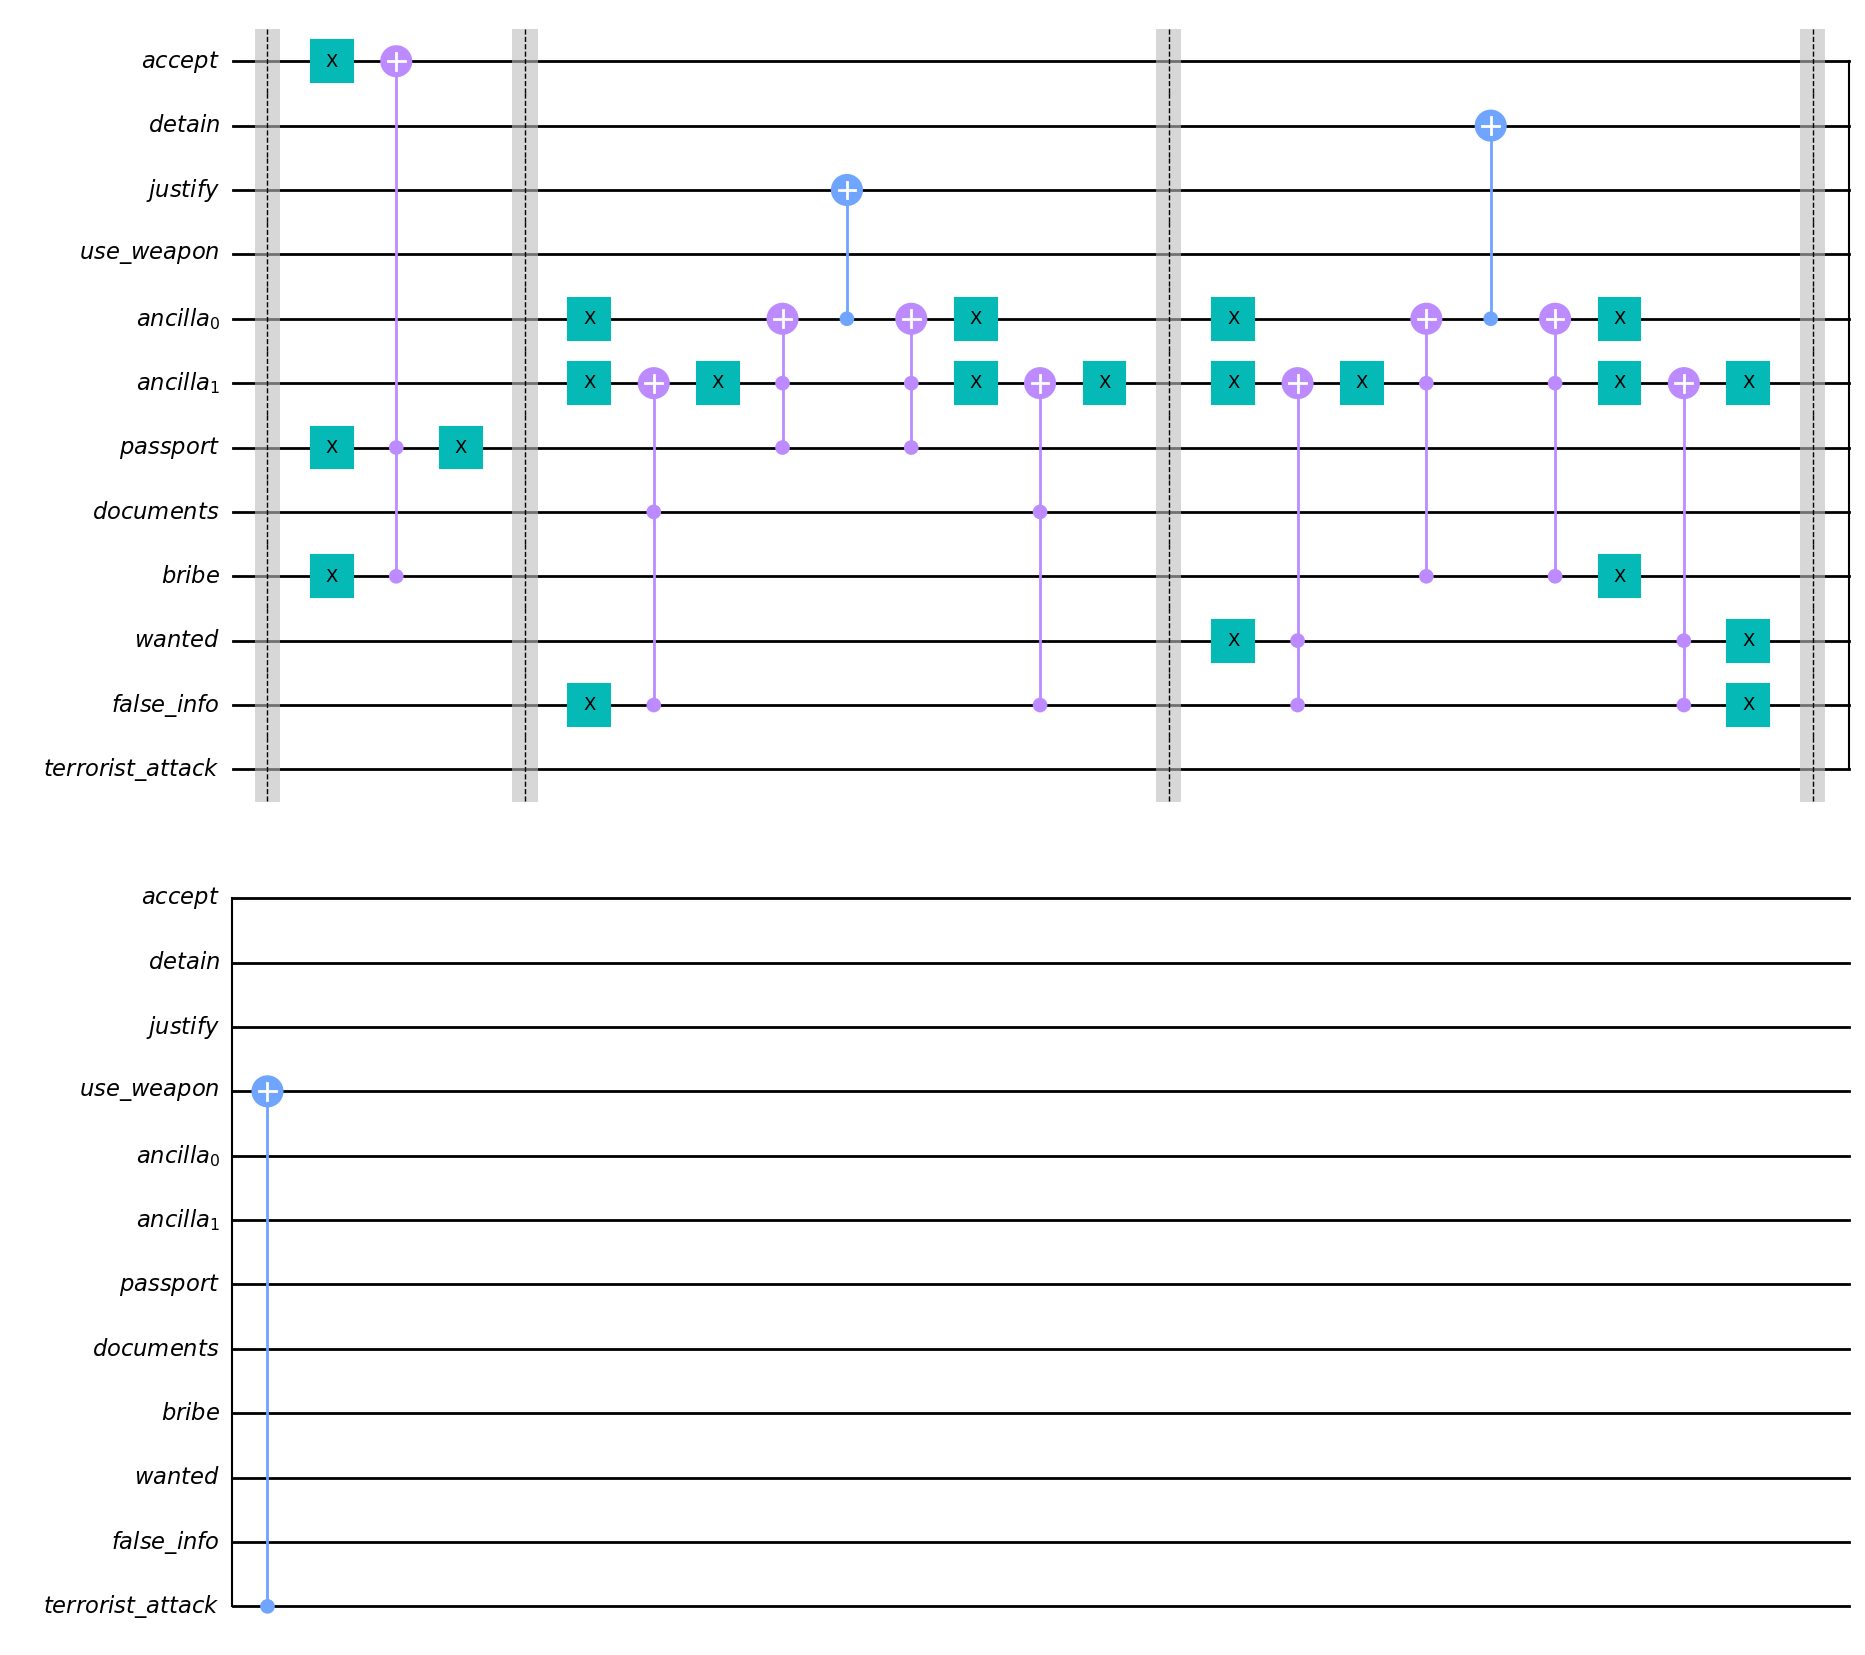

<IPython.core.display.Latex object>

In [192]:
qc = QuantumCircuit(accept, detain, justify, weapon, ancilla, passport, other_documents, bribe, wanted, false_info, attack)

#qc.x(passport)

qc.barrier()

qc.x(accept)
qc.x(bribe)
qc.x(passport)
qc.ccx(bribe, passport, accept)
qc.x(passport)

qc.barrier()

qc.x(ancilla[-1])
qc.x(ancilla[-2])
qc.x(false_info)
qc.ccx(false_info, other_documents, ancilla[-1])
qc.x(ancilla[-1])
qc.ccx(passport, ancilla[-1], ancilla[-2])
qc.cx(ancilla[-2], justify)
qc.ccx(passport, ancilla[-1], ancilla[-2])
qc.x(ancilla[-1])
qc.ccx(false_info, other_documents, ancilla[-1])
qc.x(ancilla[-1])
qc.x(ancilla[-2])

qc.barrier()


qc.x(wanted)
qc.x(ancilla[-1])
qc.x(ancilla[-2])
qc.ccx(false_info, wanted, ancilla[-1])
qc.x(ancilla[-1])
qc.ccx(bribe, ancilla[-1], ancilla[-2])
qc.cx(ancilla[-2], detain)
qc.ccx(bribe, ancilla[-1], ancilla[-2])
qc.x(ancilla[-1])
qc.ccx(false_info, wanted, ancilla[-1])
qc.x(false_info)
qc.x(wanted)
qc.x(bribe)
qc.x(ancilla[-1])
qc.x(ancilla[-2])

qc.barrier()

qc.cx(attack, weapon)

display(qc.draw("mpl"))
Statevector(qc).draw("latex")

In [60]:
qc.depth()

21

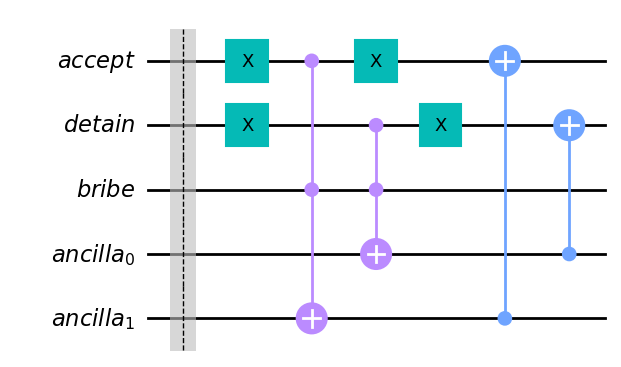

<IPython.core.display.Latex object>

In [4]:
qc = QuantumCircuit(accept, detain, bribe, ancilla)


qc.barrier()

qc.x(accept)
qc.x(detain)
qc.ccx(accept, bribe, ancilla[-1])
qc.ccx(detain, bribe, ancilla[-2])
qc.x(detain)
qc.x(accept)


qc.cx(ancilla[-1], accept)
qc.cx(ancilla[-2], detain)


display(qc.draw("mpl"))
Statevector(qc).draw("latex")

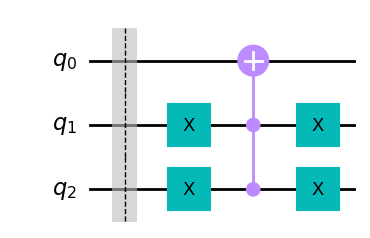

<IPython.core.display.Latex object>

In [16]:
qc_or = QuantumCircuit(3)


qc_or.barrier()

qc_or.x(range(1,3))
qc_or.ccx(2, 1, 0)
qc_or.x(range(1,3))

display(qc_or.draw("mpl"))
Statevector(qc_or).draw("latex")

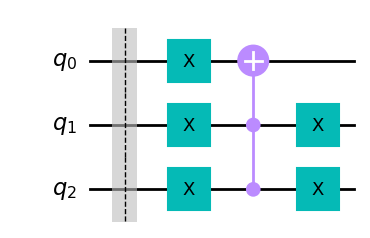

<IPython.core.display.Latex object>

In [23]:
qc_d = QuantumCircuit(3)

qc_d.barrier()

qc_d.x([0, 1,2])
qc_d.ccx(2, 1, 0)
qc_d.x([1,2])

display(qc_d.draw("mpl"))
Statevector(qc_d).draw("latex")

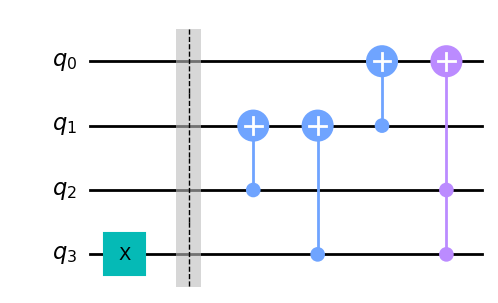

<IPython.core.display.Latex object>

In [66]:
qc_c = QuantumCircuit(4)

#qc_c.x(1)
#qc_c.x(2)
qc_c.x(3)

qc_c.barrier()



qc_c.cx(2, 1)
qc_c.cx(3, 1)
qc_c.cx(1, 0)
qc_c.ccx(3, 2, 0)

display(qc_c.draw("mpl"))
Statevector(qc_c).draw("latex")

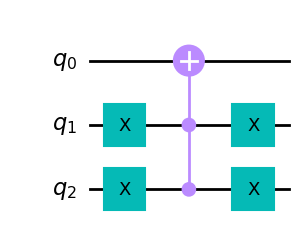

In [39]:
test = QuantumCircuit(3)

test.x([-1, -2])

test.ccx(-1, -2, -3)
test.x([-1, -2])

test.draw("mpl")

In [40]:
sim = Aer.get_backend("unitary_simulator")
job = sim.run(test)
array_to_latex(job.result().get_unitary(test))

<IPython.core.display.Latex object>

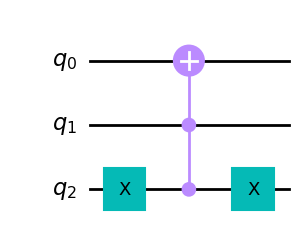

In [43]:
test2 = QuantumCircuit(3)

test2.x(-1)

test2.ccx(-1, -2, -3)
test2.x(-1)

test2.draw("mpl")

In [44]:
job = sim.run(test2)
array_to_latex(job.result().get_unitary(test2))

<IPython.core.display.Latex object>

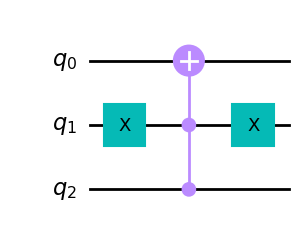

In [45]:
test3 = QuantumCircuit(3)

test3.x(-2)
test3.ccx(-1, -2, -3)
test3.x(-2)

test3.draw("mpl")

In [46]:
job = sim.run(test3)
array_to_latex(job.result().get_unitary(test3))

<IPython.core.display.Latex object>

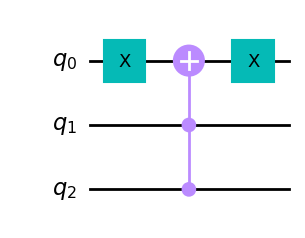

In [47]:
test4 = QuantumCircuit(3)

test4.x(-3)
test4.ccx(-1, -2, -3)
test4.x(-3)

test4.draw("mpl")

In [48]:
job = sim.run(test4)
array_to_latex(job.result().get_unitary(test4))

<IPython.core.display.Latex object>

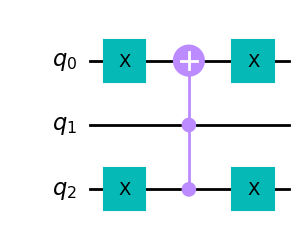

In [49]:
test5 = QuantumCircuit(3)

test5.x(-3)
test5.x(-1)
test5.ccx(-1, -2, -3)
test5.x(-1)
test5.x(-3)

test5.draw("mpl")

In [50]:
job = sim.run(test5)
array_to_latex(job.result().get_unitary(test5))

<IPython.core.display.Latex object>

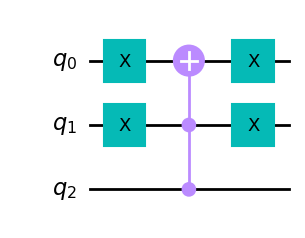

In [57]:
test6 = QuantumCircuit(3)

test6.x(-2)
test6.x(-3)
test6.ccx(-1, -2, -3)
test6.x(-3)
test6.x(-2)

test6.draw("mpl")

In [58]:
job = sim.run(test6)
array_to_latex(job.result().get_unitary(test6))

<IPython.core.display.Latex object>

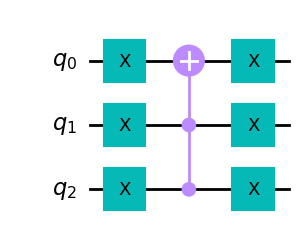

In [61]:
test7 = QuantumCircuit(3)

test7.x(range(3))
test7.ccx(-1, -2, -3)
test7.x(range(3))


test7.draw("mpl")

In [62]:
job = sim.run(test7)
array_to_latex(job.result().get_unitary(test7))

<IPython.core.display.Latex object>

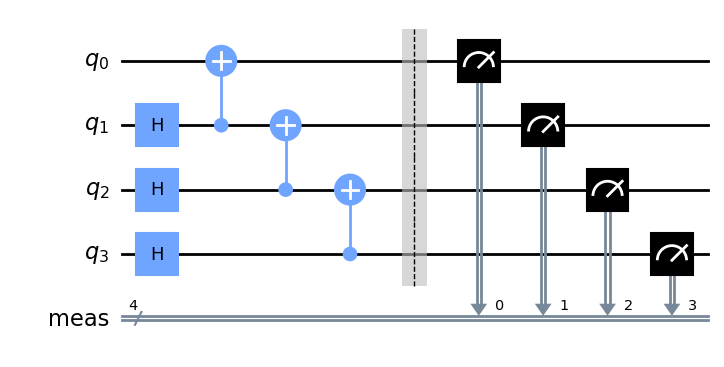

In [198]:
qc = QuantumCircuit(4)
qc.h(1)
qc.h(2)
qc.h(3)
qc.cx(1, 0)
qc.cx(2, 1)
qc.cx(3, 2)

qc.measure_all()
qc.draw("mpl")

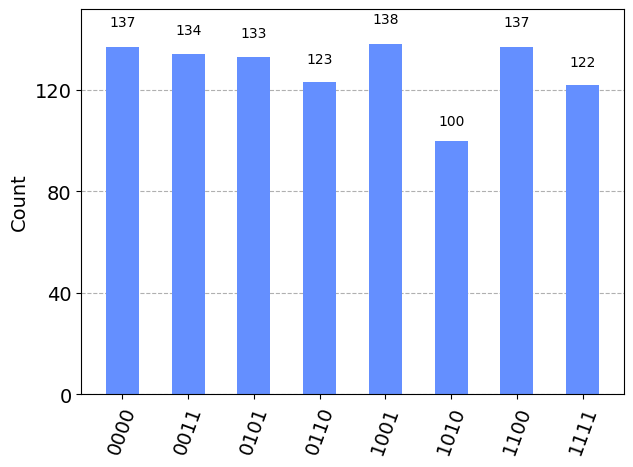

In [199]:
sim = Aer.get_backend("aer_simulator")
results = sim.run(qc).result().get_counts()
plot_histogram(results)